In [2]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})
plt.rcParams['figure.figsize'] = (30, 15)

This journal documents the manipulation of PV installation data for the USA. This covers selection of data, and weighting by marketshare.

In [3]:
cwd = os.getcwd() #grabs current working directory
df_installs_raw = pd.read_csv(cwd+"/../../PV_DEMICE/baselines/SupportingMaterial/PVInstalls_USA_AllSources.csv", index_col='Year')

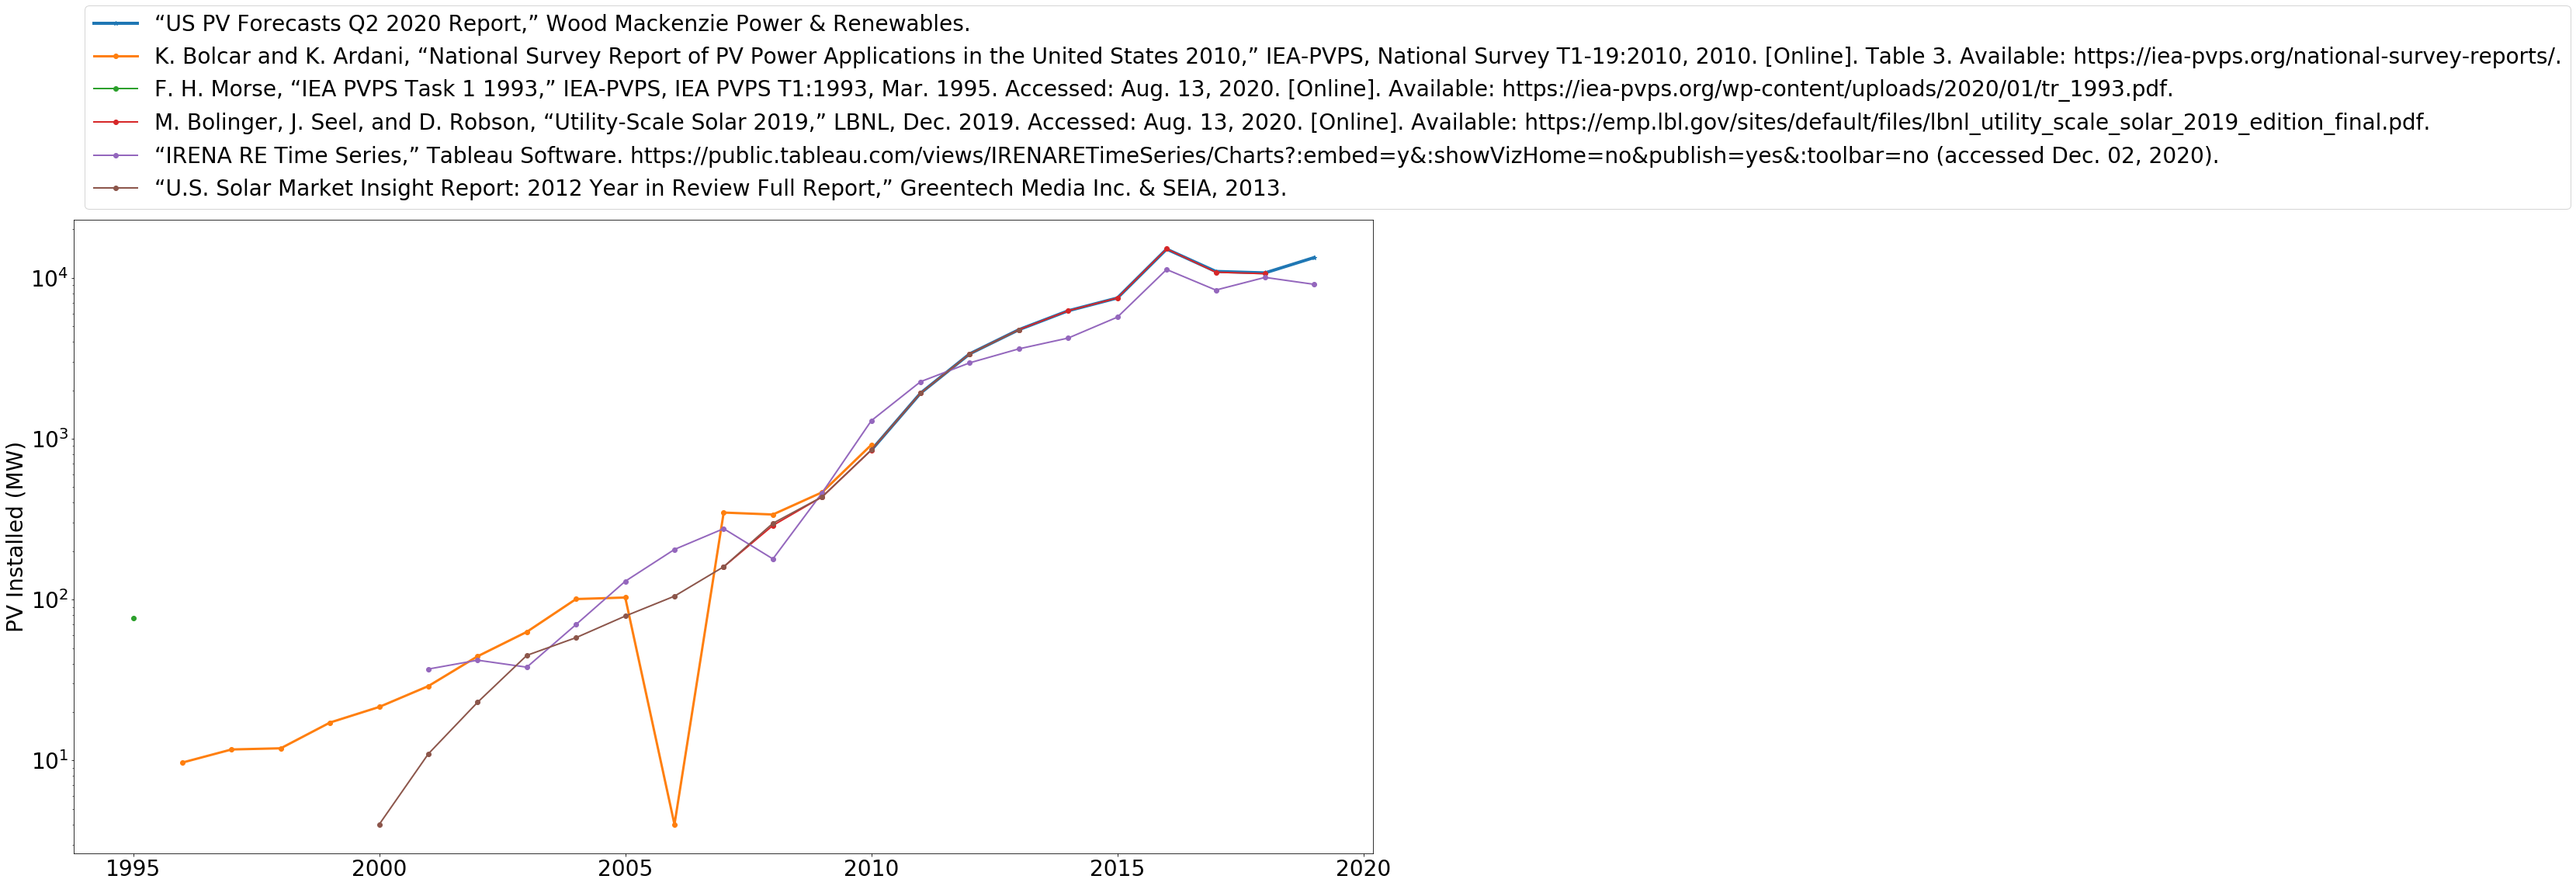

In [4]:
sources = df_installs_raw.columns
#print(len(sources))
plt.plot(df_installs_raw.index,df_installs_raw[sources[0]],lw=4,marker='*',label=sources[0])
plt.plot(df_installs_raw.index,df_installs_raw[sources[1]],lw=3,marker='o',label=sources[1])
plt.plot(df_installs_raw.index,df_installs_raw[sources[2]],lw=2,marker='o',label=sources[2])
plt.plot(df_installs_raw.index,df_installs_raw[sources[3]],lw=2,marker='o',label=sources[3])
plt.plot(df_installs_raw.index,df_installs_raw[sources[4]],lw=2,marker='o',label=sources[4])
plt.plot(df_installs_raw.index,df_installs_raw[sources[5]],lw=2,marker='o',label=sources[5])
plt.yscale('log')
plt.ylabel('PV Installed (MW)')
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
#plt.plot(df_installs_raw, marker='o')

# Select the data to use for installs

The IRENA is consistently lower than the other sources from 2012 through the present. Given that all other sources are in agreement, we will select one of these data sets to use for installation data, rather than IRENA. In this case, we will select the Wood Mackenzie Power & Renewables quarterly reports and PV forecasts from 2010 through 2019.

In [5]:
installs_2010_2019 = df_installs_raw.loc[(df_installs_raw.index>=2010) & (df_installs_raw.index<=2019)]
installs_recent = pd.DataFrame(installs_2010_2019[sources[0]])
installs_recent.columns = ['installed_pv_MW']
print(installs_recent)

      installed_pv_MW
Year                 
2010          848.588
2011         1920.510
2012         3373.427
2013         4765.802
2014         6243.873
2015         7500.642
2016        15095.640
2017        10969.090
2018        10740.380
2019        13385.900


Only 1 dataset exists from 1995 to 2000, from IEA PVPS 2010 National Survey report. This seems to track reasonably well with Wood Mackenzie data between 2008 and 2010. Therefore, this will be used up to 2010. 

In [6]:
installs_upto2010 = df_installs_raw.loc[(df_installs_raw.index<2010)]
installs_old = pd.DataFrame(installs_upto2010[sources[1]])
installs_old.columns = ['installed_pv_MW']
print(installs_old)

      installed_pv_MW
Year                 
1995              NaN
1996              9.7
1997             11.7
1998             11.9
1999             17.2
2000             21.5
2001             29.0
2002             44.4
2003             63.0
2004            100.8
2005            103.0
2006              4.0
2007            347.5
2008            338.0
2009            464.5


However, there are 2 problems with this data. 1) There is an error in the original published table, such that it appears only 4 MW of PV were installed in 2006. To address this problem we will utilize SEIA & GTM/Wood Mackenzie data for 2006. 2) Due to the way the original data was presented, we had to calculate the difference between years to capture installed PV data, meaning that we don't have data for 1995. To address this problem, we will fill in the data point from “IEA PVPS Task 1 1997,” IEA-PVPS, IEA PVPS T1:1997, Mar. 1997. Accessed: Aug. 13, 2020. [Online]. Available: https://iea-pvps.org/wp-content/uploads/2020/01/tr_1995_01.pdf, which specifies the added PV in 1995 in the US (Table 2.2).


In [7]:
#dealing with 2006 error
installs_old['installed_pv_MW'][2006] = df_installs_raw[sources[5]][2006]

#dealing with 1995 error
installs_old['installed_pv_MW'][1995] = 12.5 #MW

#print(installs_old)

### Collect the installation data together into a single df

Text(0.5, 1.0, 'Installations of PV in the USA (MW) since 1995')

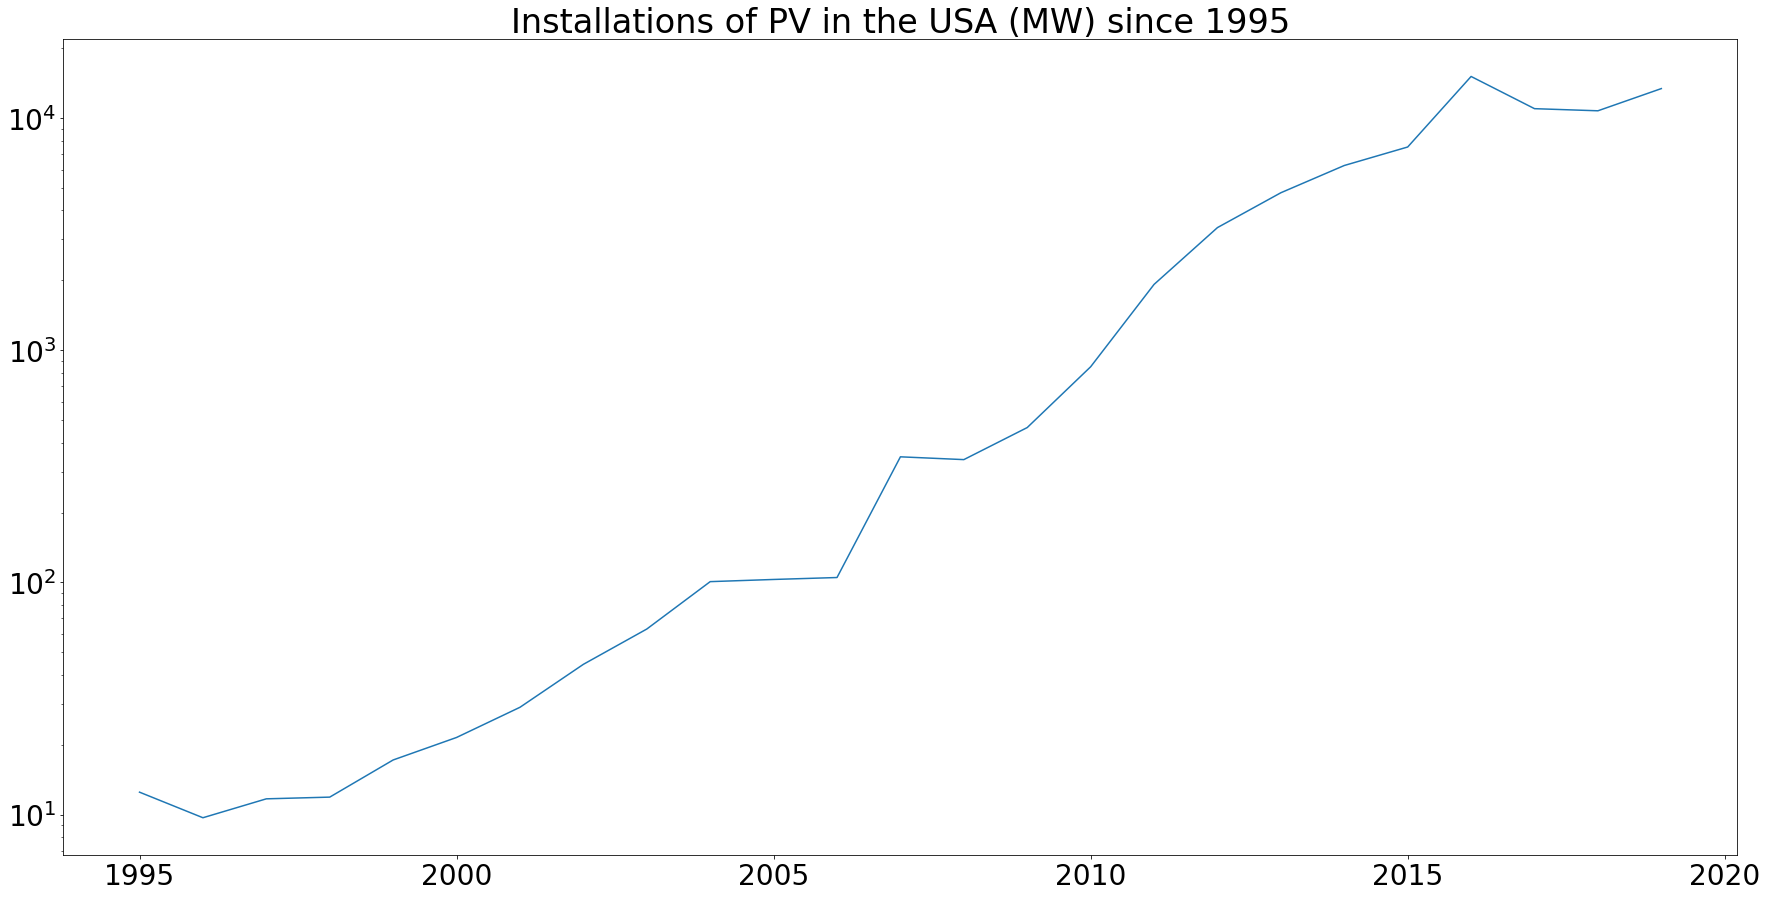

In [35]:
installs = pd.concat([installs_old,installs_recent])
plt.plot(installs)
plt.yscale('log')
plt.title('Installations of PV in the USA (MW) since 1995')

# Marketshare weight the installation data for percent of Silicon vs Thin Film

In addition to compiling a single installation record for 1995 through the present, this data is total cumulative, but the tool it currently considering silicon technology only. Especially in the United States, where First Solar holds significant marketshare, this distinction is important. Currently, we also do not feel it is critical track circular economy of CdTe given that First Solar already recycles all their panels.

In [9]:
cwd = os.getcwd() #grabs current working directory
df_raw_mrktshr_siVtf = pd.read_csv(cwd+"/../../PV_DEMICE/baselines/SupportingMaterial/MarketShare_US_siliconVSthinfilm.csv", index_col='Year')

(0, 1.1)

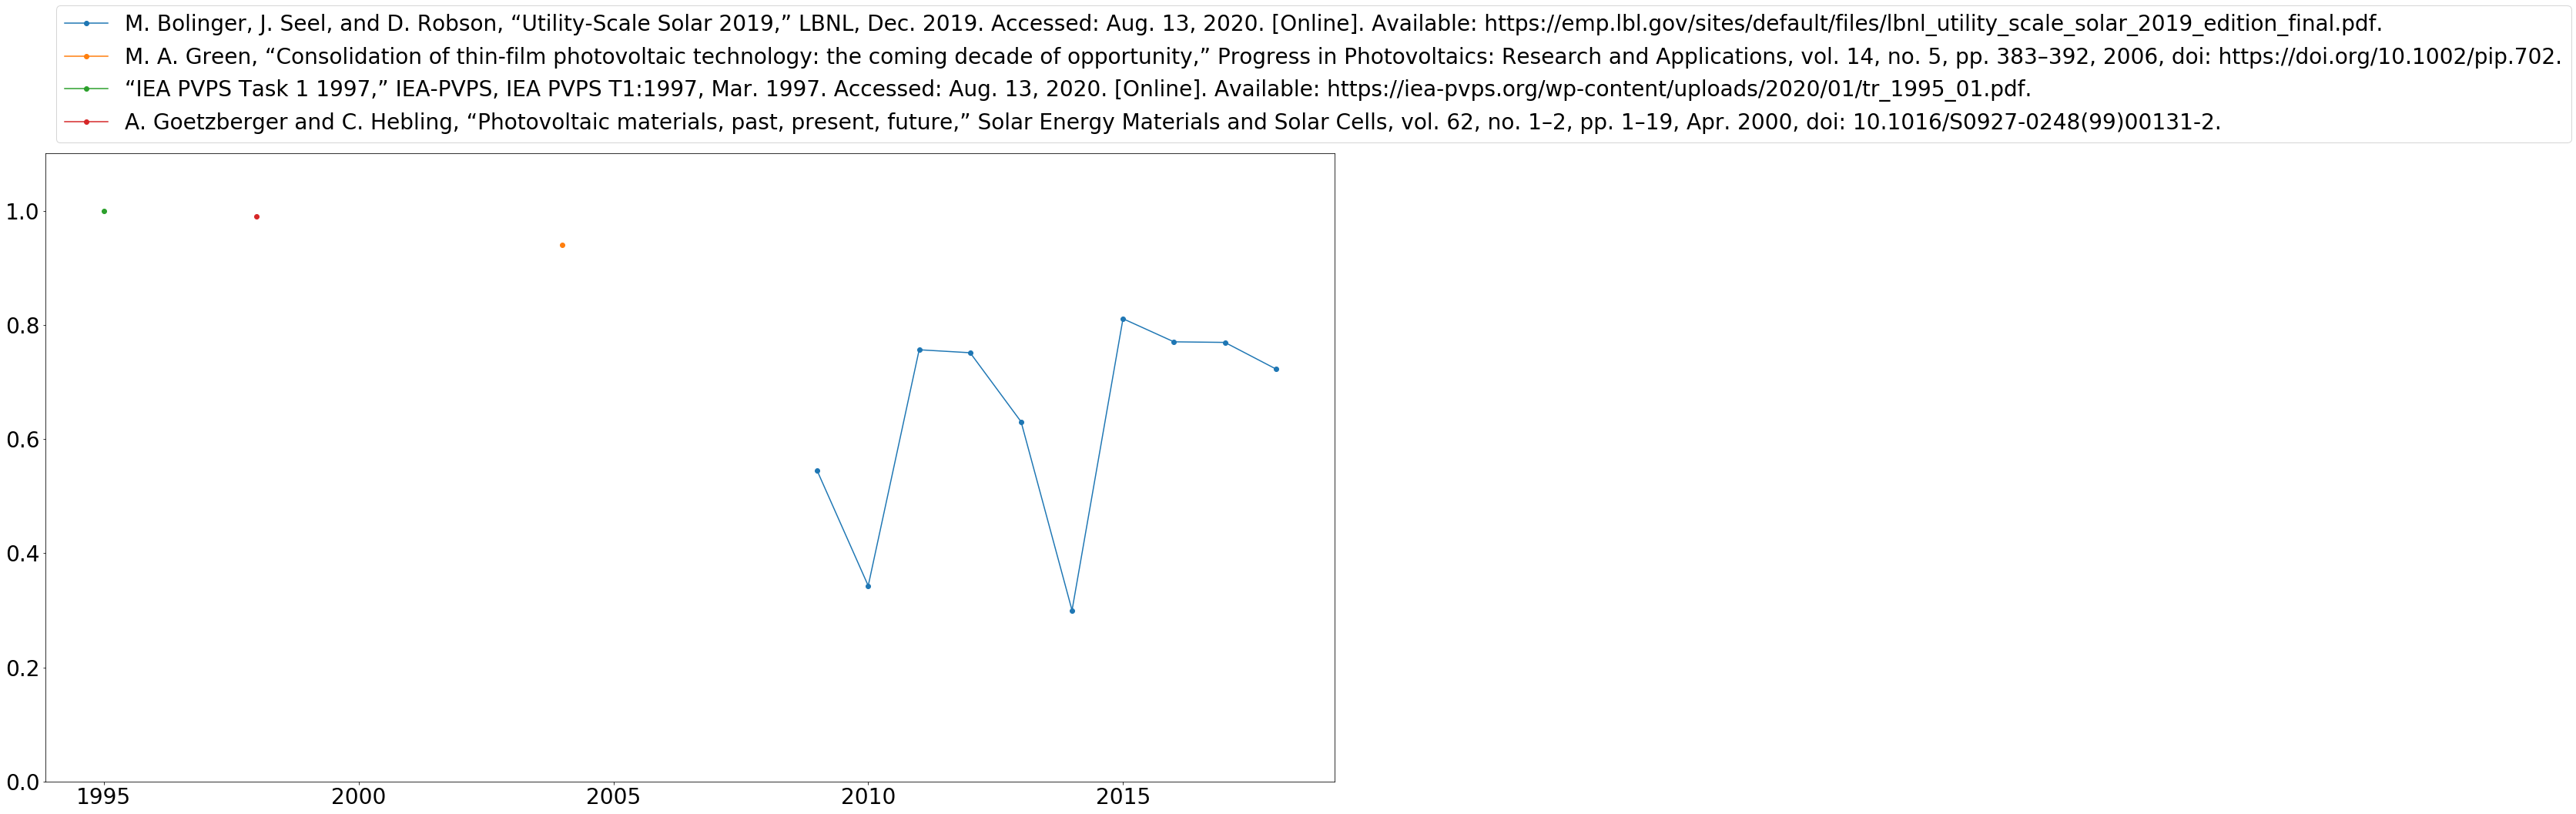

In [19]:
refs = df_raw_mrktshr_siVtf.columns
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[0]],marker='o',label=refs[0])
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[1]],marker='o',label=refs[1])
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[2]],marker='o',label=refs[2])
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[3]],marker='o',label=refs[3])
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.ylim(0,1.1)

Since there is no overlap among these resources, we will simply consolidate into a single historical marketshare.

Mints does have marketshare data overlapping the late 2000s to the present, however, this data is based on MFG capcity and shipments at a global scale. This PV installation baseline is for the USA, and is focused on the install side, rather than the MFG capacity side.

In [29]:
#bfill function "collapses" values from all columns into a single column, then make a df of only that data
df_raw_mrktshr_siVtf['All_Marketshare'] = pd.to_numeric(df_raw_mrktshr_siVtf[refs].bfill(axis=1).iloc[:, 0], errors='coerce')
df_mrktshr_us =  pd.DataFrame(df_raw_mrktshr_siVtf['All_Marketshare'])
#print( df_mrktshr_us)

Text(0.5, 1.0, 'Marketshare of Silicon PV installed since 1995')

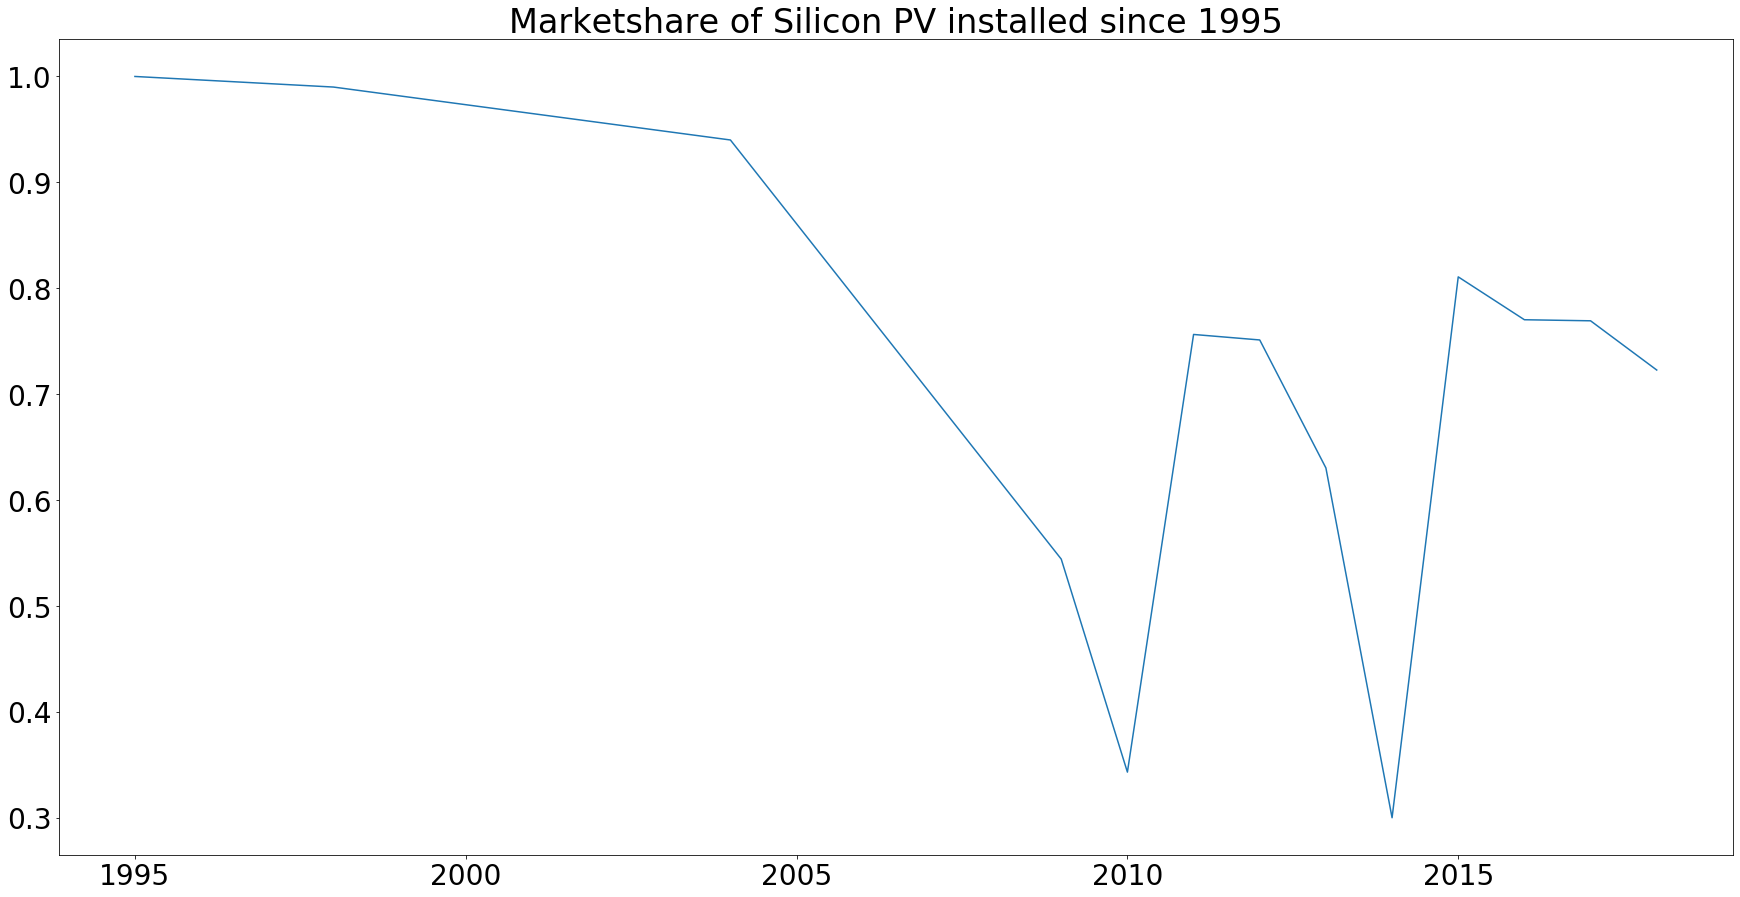

In [36]:
df_mrktshr_us_si_complete = df_mrktshr_us.interpolate(limit_area='inside')
plt.plot(df_mrktshr_us_si_complete)
plt.title('Marketshare of Silicon PV installed since 1995')

# Marketshare weight PV installs by percent Silicon
Now we have a marketshare percentage of silicon for 1995 through 2018. We will multiply the PV installs by this silicon marketshare to get the MW of silicon PV installed in the US since 1995.

Text(0.5, 1.0, 'Silicon PV Installations (MW) in the USA, 1995 through 2018')

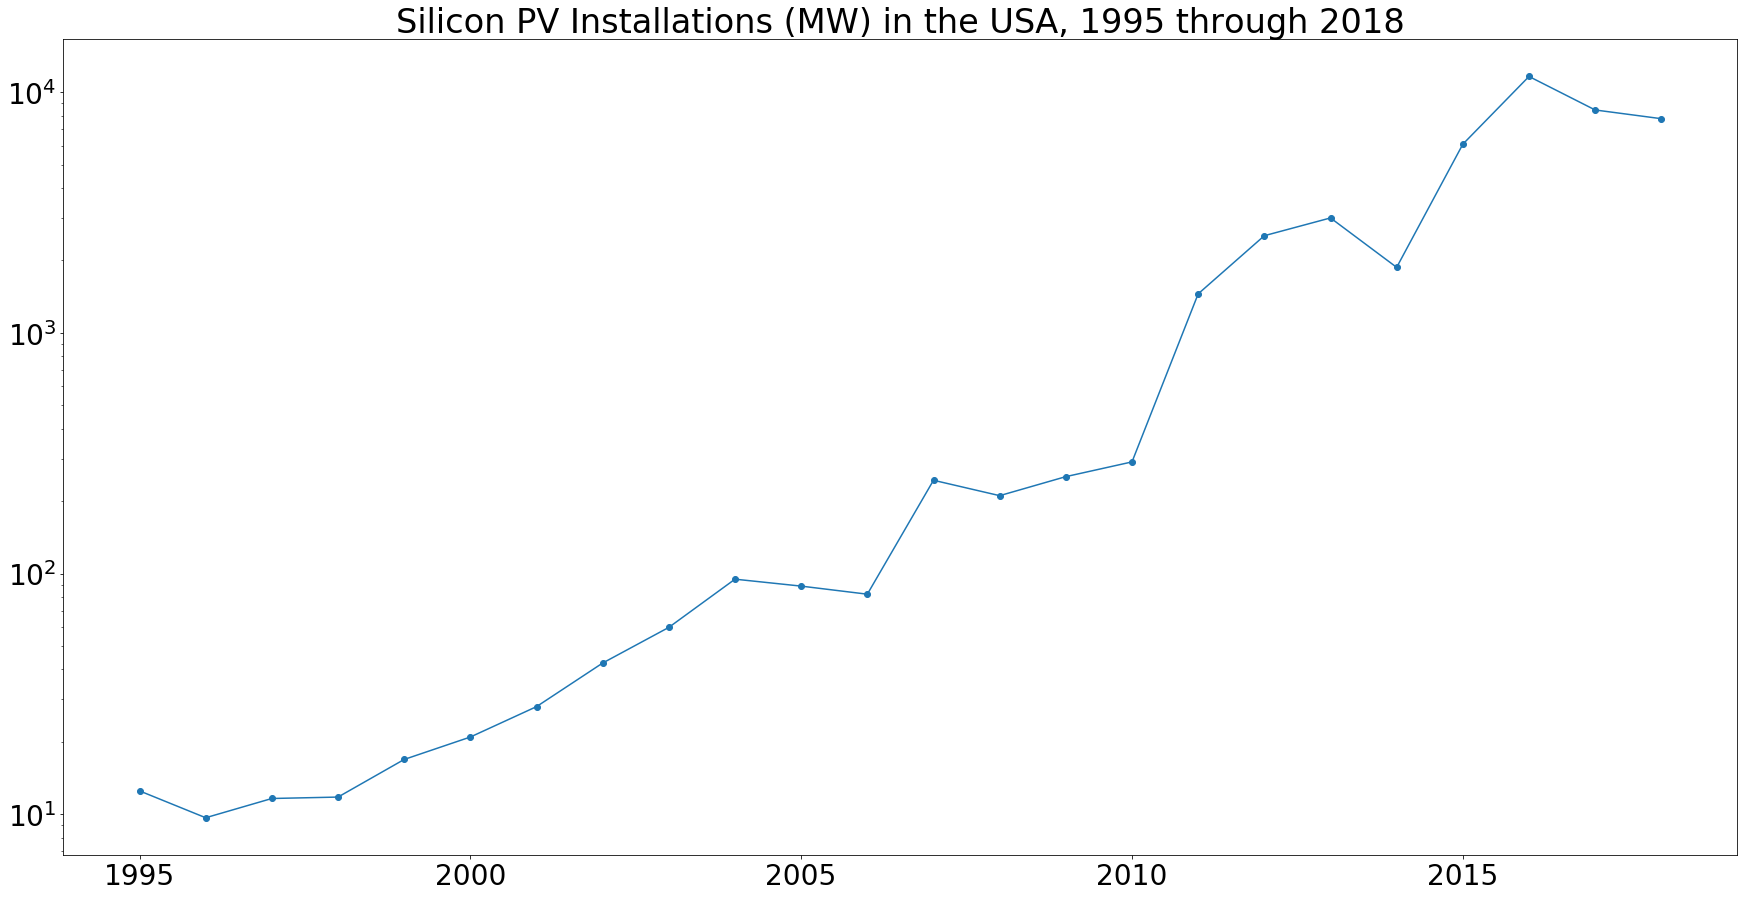

In [48]:
dfs = [installs,df_mrktshr_us_si_complete]
df = pd.concat(dfs, axis=1, join='inner')
df_clean = df.dropna()
us_si_installs = df_clean.agg('prod', axis='columns')

#print(us_si_installs)
plt.plot(us_si_installs, marker='o')
plt.yscale('log')
plt.title('Silicon PV Installations (MW) in the USA, 1995 through 2018')

In [ ]:
us_si_installs.to_csv(cwd+'/../../PV_DEMICE/baselines/SupportingMaterial/output_USA_SiPV_installs.csv', index=True)